## **3. Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

### **필요 패키지 import**

In [1]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import pandas as pd
import copy
import numpy as np

### **데이터 전처리**



데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.

In [2]:
# train_data = [
#   "정말 맛있습니다. 추천합니다.",
#   "기대했던 것보단 별로였네요.",
#   "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
#   "완전 최고입니다! 재방문 의사 있습니다.",
#   "음식도 서비스도 다 만족스러웠습니다.",
#   "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
#   "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
#   "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
#   "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
#   "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
# ]

test_words = ["영화", "기대", "감독", "배우", "평점"]

In [3]:
df = pd.read_csv('reviews_1.csv')
train_data = df['sentence'].to_list()
len(train_data)

1874

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

In [4]:
tokenizer = Okt()

In [5]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    # tokens = tokenizer.morphs(sent, stem=True)
    tokens = tokenizer.nouns(sent)
    tokenized.append(tokens)

  return tokenized

In [6]:
train_tokenized = make_tokenized(train_data)

100%|██████████| 1874/1874 [00:06<00:00, 310.59it/s]


In [7]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1

100%|██████████| 1874/1874 [00:00<00:00, 716968.50it/s]


In [8]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count)[:10])

[('영화', 844), ('최고', 239), ('진짜', 180), ('감동', 167), ('꼭', 139), ('탑건', 135), ('스토리', 131), ('보고', 121), ('말', 112), ('편', 109)]


In [9]:
w2i = {}
for pair in tqdm(word_count):
  if pair[0] not in w2i:
    w2i[pair[0]] = len(w2i)

i2w={v:k for k,v in w2i.items()}

100%|██████████| 2826/2826 [00:00<00:00, 1967320.02it/s]


In [10]:
print(train_tokenized[:10])
print(len(w2i))

[['로라', '나', '오히려', '전투씬', '조금', '단점', '그거'], ['평점', '제대로', '음', '점', '시청', '점', '명', '참여', '평점', '걸', '나중', '봄', '연기', '볼', '하나', '스토리', '전혀'], ['호불호', '개인', '저', '호'], ['평가', '대작'], ['두', '주인공', '감성', '연기', '또', '번', '매료'], ['톰', '크루즈', '꼭', '영화관', '다음', '내용'], ['별로', '정치', '병영'], ['최고', '최고', '최고'], ['고레', '히로', '카', '의', '영화', '생각', '아쉬움', '감독', '배우', '간', '의', '국적', '언어', '문화', '등등', '차이점', '극복', '위해', '영화', '게', '생각', '조심', '주연', '진', '이외', '단역', '배우', '까메오', '재미', '추천'], ['탑건', '다시', '기분']]
2826


### 다음은 Word2Vec을 학습시키는 대표적인 방법인 Skipgram과 CBow를 다룹니다. 

* Cbow는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [11]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.y.append(id)

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          self.x.append(id)
          self.y.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [12]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(cbow_set)[:10])
print(list(skipgram_set)[:10])

100%|██████████| 1874/1874 [00:00<00:00, 377002.53it/s]

[(tensor([1193,   57,  338,  115]), tensor(304)), (tensor([ 57, 304, 115, 769]), tensor(338)), (tensor([304, 338, 769, 770]), tensor(115)), (tensor([ 20, 121,  18, 380]), tensor(166)), (tensor([121, 166, 380,  18]), tensor(18)), (tensor([166,  18,  18, 381]), tensor(380)), (tensor([  18,  380,  381, 1194]), tensor(18)), (tensor([ 380,   18, 1194,   20]), tensor(381)), (tensor([ 18, 381,  20, 105]), tensor(1194)), (tensor([ 381, 1194,  105,  272]), tensor(20))]
[(tensor(304), tensor([1193,   57,  338,  115])), (tensor(338), tensor([ 57, 304, 115, 769])), (tensor(115), tensor([304, 338, 769, 770])), (tensor(166), tensor([ 20, 121,  18, 380])), (tensor(18), tensor([121, 166, 380,  18])), (tensor(380), tensor([166,  18,  18, 381])), (tensor(18), tensor([  18,  380,  381, 1194])), (tensor(381), tensor([ 380,   18, 1194,   20])), (tensor(1194), tensor([ 18, 381,  20, 105])), (tensor(20), tensor([ 381, 1194,  105,  272]))]


### **모델 Class 구현**

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [13]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  '''
    Input: (B, 2W)
    Output: (B, V)
  '''
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [16]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim, window_size=2):
    super(SkipGram, self).__init__()
    self.window_size = window_size
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(self.vocab_size, dim, sparse=True)
    self.linears = nn.ModuleList([nn.Linear(dim, self.vocab_size) for _ in range(self.window_size * 2)])
    self.softmax = nn.Softmax(dim=1)

  '''
    Input: (B, V)
    Output: (B, 2W, V)
  '''
    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    outputs = []
    for linear in self.linears:
      logit = linear(embeddings)
      outputs.append(self.softmax(logit))
      
    return torch.stack(outputs, dim=1)

두 가지 모델을 생성합니다.

In [17]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [18]:
batch_size = 32
learning_rate = 5e-4
num_epochs = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [19]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):

  for batch in cbow_loader:
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Epoch: {e}, Train loss: {loss.item()}")

print("Finished.")

Epoch: 1, Train loss: 8.498250007629395
Epoch: 2, Train loss: 8.457849502563477
Epoch: 3, Train loss: 8.417511940002441
Epoch: 4, Train loss: 8.37724494934082
Epoch: 5, Train loss: 8.337059020996094
Epoch: 6, Train loss: 8.296968460083008
Epoch: 7, Train loss: 8.256991386413574
Epoch: 8, Train loss: 8.217153549194336
Epoch: 9, Train loss: 8.177488327026367
Epoch: 10, Train loss: 8.138035774230957
Epoch: 11, Train loss: 8.098849296569824
Epoch: 12, Train loss: 8.059972763061523
Epoch: 13, Train loss: 8.021461486816406
Epoch: 14, Train loss: 7.983346939086914
Epoch: 15, Train loss: 7.945651531219482
Epoch: 16, Train loss: 7.90838623046875
Epoch: 17, Train loss: 7.871547698974609
Epoch: 18, Train loss: 7.8351311683654785
Epoch: 19, Train loss: 7.799124240875244
Epoch: 20, Train loss: 7.763519287109375
Epoch: 21, Train loss: 7.728308200836182
Epoch: 22, Train loss: 7.693483829498291
Epoch: 23, Train loss: 7.659040451049805
Epoch: 24, Train loss: 7.62497091293335
Epoch: 25, Train loss: 7.59

다음으로 Skip-gram 모델 학습입니다.

In [20]:
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

In [21]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=0.05)
loss_function = nn.CrossEntropyLoss(reduction='sum')

for e in range(1, num_epochs+1):
  for batch in skipgram_loader:
    x, y = batch
    y_one_hot = F.one_hot(y, num_classes=len(w2i)).type(torch.FloatTensor)
    x, y_one_hot = x.to(device), y_one_hot.to(device) # (B, W), (B)

    output = skipgram(x)  # (B, V)
    optim.zero_grad()
    loss = loss_function(output, y_one_hot)
    loss.backward()
    optim.step()

  print(f"Epoch: {e}, Train loss: {loss.item()}")
  # print(output, y_one_hot)

print("Finished.")

Epoch: 1, Train loss: 133.0821990966797
Epoch: 2, Train loss: 133.08203125
Epoch: 3, Train loss: 133.0818634033203
Epoch: 4, Train loss: 133.08169555664062
Epoch: 5, Train loss: 133.08151245117188
Epoch: 6, Train loss: 133.0813446044922
Epoch: 7, Train loss: 133.0811767578125
Epoch: 8, Train loss: 133.08099365234375
Epoch: 9, Train loss: 133.080810546875
Epoch: 10, Train loss: 133.08062744140625
Epoch: 11, Train loss: 133.08045959472656
Epoch: 12, Train loss: 133.0802459716797
Epoch: 13, Train loss: 133.08009338378906
Epoch: 14, Train loss: 133.07992553710938
Epoch: 15, Train loss: 133.07977294921875
Epoch: 16, Train loss: 133.07962036132812
Epoch: 17, Train loss: 133.07949829101562
Epoch: 18, Train loss: 133.07937622070312
Epoch: 19, Train loss: 133.07931518554688
Epoch: 20, Train loss: 133.07925415039062
Epoch: 21, Train loss: 133.0794677734375
Epoch: 22, Train loss: 133.080078125
Epoch: 23, Train loss: 133.08203125
Epoch: 24, Train loss: 133.09202575683594
Epoch: 25, Train loss: 133

### **테스트**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [22]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 영화
tensor([-1.1474e+00, -4.1653e-01, -1.7130e+00, -2.9237e-01, -7.5269e-01,
         1.5579e-01,  1.4820e+00, -1.2933e+00, -4.5133e-01,  5.8596e-01,
        -1.0201e+00,  6.9720e-01, -6.1595e-01, -9.5778e-01,  9.8412e-01,
         8.1420e-01,  7.5689e-01,  1.6650e-01, -4.4857e-01, -1.2358e-01,
        -3.2547e-01,  1.6708e-02,  1.1046e+00, -2.0140e+00,  9.6500e-01,
         1.0175e-01, -8.7717e-01,  7.4379e-01,  7.9628e-01, -3.7616e-03,
         3.4324e-01,  1.8082e+00,  1.1770e-01,  6.4805e-01,  1.2161e+00,
        -9.5742e-01, -6.5795e-01,  9.1731e-01,  6.5131e-01, -1.8505e+00,
         1.5873e+00,  8.6331e-03,  1.3548e+00, -3.9315e-01,  1.5977e-01,
         6.7124e-01, -6.5777e-01,  1.4380e+00,  2.4168e-01,  3.6840e-01,
        -1.4070e+00, -9.6811e-01,  3.0780e-01, -1.0392e+00, -1.7469e-01,
         1.9003e+00,  7.1217e-01, -5.6810e-01, -1.2555e+00,  5.8535e-01,
         1.1837e+00,  5.8946e-01,  3.9897e-01,  8.9005e-01,  7.7362e-01,
        -8.4691e-01,  5.9058e-01,  4.6790e

In [23]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 영화
tensor(2.6131, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 기대
tensor(2.8409, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 감독
tensor(2.6291, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 배우
tensor(2.9281, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 평점
tensor(2.7298, device='cuda:0', grad_fn=<UnbindBackward0>)


In [24]:
test_words

['영화', '기대', '감독', '배우', '평점']

In [25]:
def most_similar(word,top_k = 5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score = torch.matmul(input_emb, skipgram.embedding.weight.transpose(1,0)).view(-1)

  _, top_k_ids = torch.topk(score, top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [27]:
for word in test_words:
    print(word, ':', most_similar(word))


영화 : ['유치', '국격', '컨져링', '승리']
기대 : ['백전노장', '투척', '이자', '나락']
감독 : ['불교', '버틀러', '년전', '음']
배우 : ['볼거리', '더', '안나', '수학자']
평점 : ['모습', '성공', '메시지', '로드']


## Word2Vec 시각화

In [28]:
from sklearn.decomposition import PCA

In [29]:
import matplotlib.pyplot as plt
# matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='NanumBarunGothic') 
# plt.rc('font', family='AppleGothic') #맥

In [30]:
skipgram.embedding.weight.data.cpu().numpy().shape

(2826, 256)

In [31]:
cbow.embedding.weight.data.cpu().numpy().shape

(2826, 256)

In [32]:
pca = PCA(n_components=2)

In [33]:
pc_weight = pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/home/koowater/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


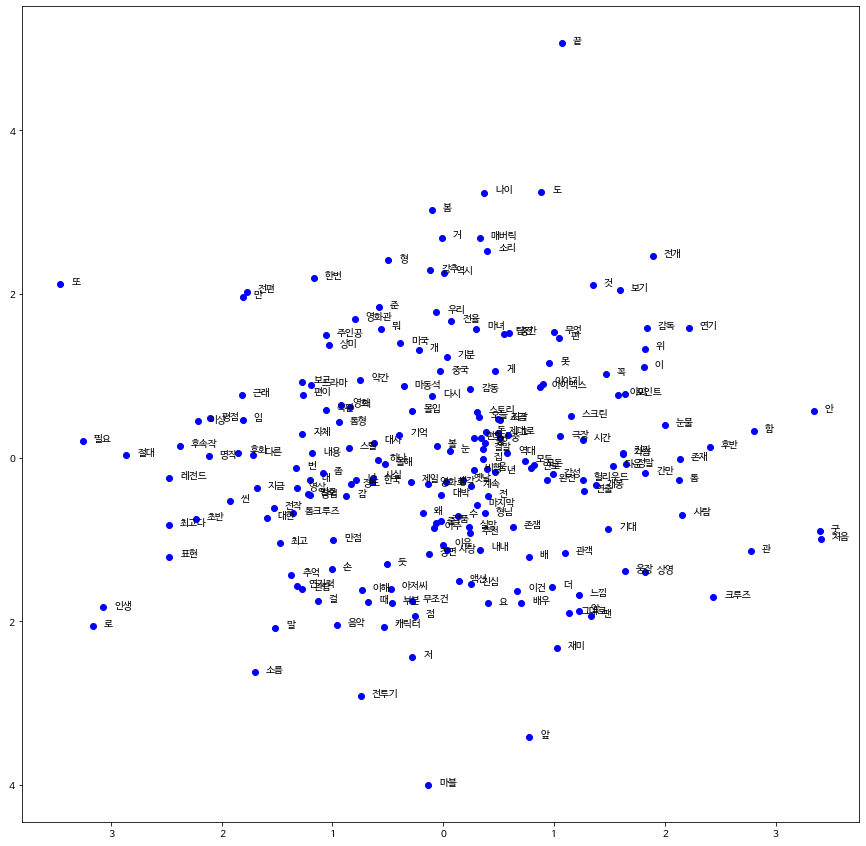

In [36]:
pc_weight = pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())
plt.figure(figsize=(15,15))
for word_id, (x_coordinate, y_coordinate) in enumerate(pc_weight[:200]):
  plt.scatter(x_coordinate, y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate+0.1, y_coordinate))

/home/koowater/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


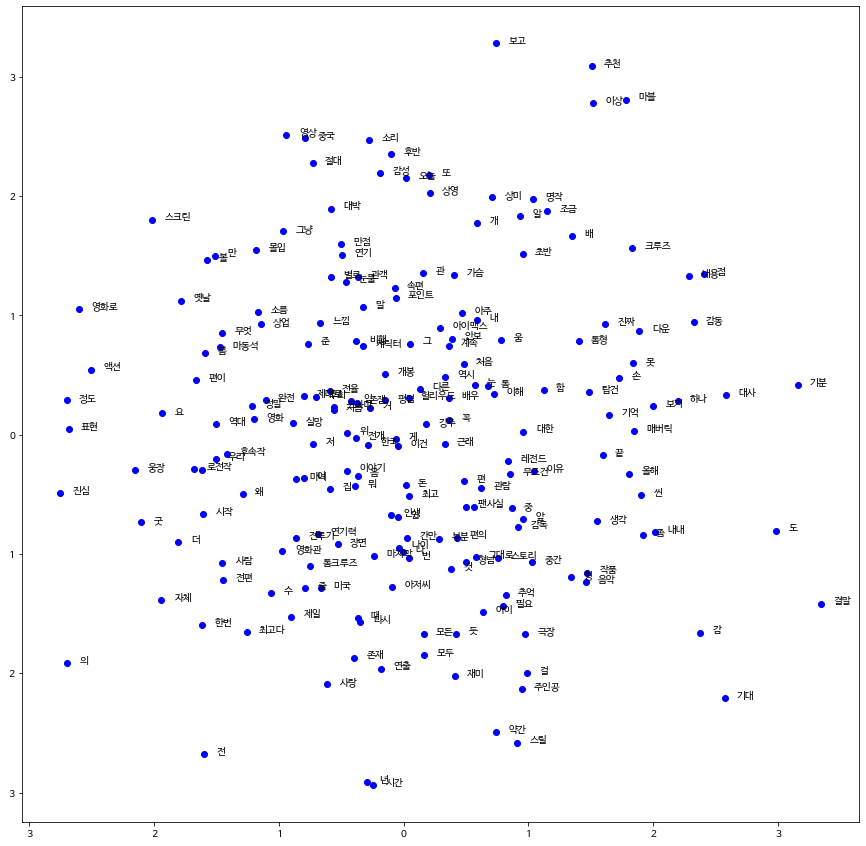

In [37]:
pc_weight = pca.fit_transform(cbow.embedding.weight.data.cpu().numpy())
plt.figure(figsize=(15,15))
for word_id,(x_coordinate, y_coordinate) in enumerate(pc_weight[:200]):
  plt.scatter(x_coordinate, y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate+0.1, y_coordinate))

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_tokenized, vector_size=100, window=2, min_count=1, workers=4, sg=0)

In [ ]:
print(model.wv.most_similar('너무')[:3])

[('하다', 0.252762109041214), ('최고', 0.2012740522623062), ('는', 0.1956762671470642)]


60